# Deep Q-Network (DQN)
---
This notebook implements a DQN agent with Unity's Udacity-modified Banana environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import time

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. 

Change the __*visible_environment*__ variable to enable training with (True) or without (False) a visible environment.

The output below indicates the utilization of a cpu or a gpu.

In [2]:
from unityagents import UnityEnvironment

visible_environment = True # set this parameter

if visible_environment == True:
    env = UnityEnvironment(file_name='../unity_environments/Banana_Linux/Banana.x86_64')
else:
    env = UnityEnvironment(file_name='../unity_environments/Banana_Linux_NoVis/Banana.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions and states
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Using device: cuda:0


### 2a. Watch an Untrained Agent


In [3]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state

#while True:
score = 0
for jj in range(100):
    eps = 0.2
    action = agent.act(state, eps)
    env_info = env.step(action)[brain_name]        # send the action to the environment    
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:
        break         

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.

Alternatively, **skip** to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Episode 100	Average Score: 0.42
Episode 200	Average Score: 3.30
Episode 300	Average Score: 6.34
Episode 400	Average Score: 9.42
Episode 489	Average Score: 13.02
Environment solved in 489 episodes!	Average Score: 13.02
	 Time to train network: 250.43 seconds


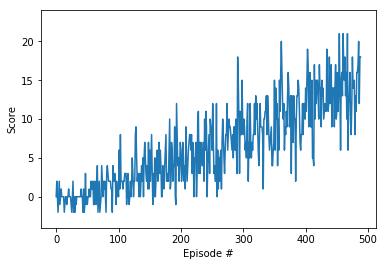

In [4]:
def plot_scores(scores, fig_indicator="normal"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.ylim((-4, 24))
    plt.show()
    
    fig_name = "Results/Figure_" + fig_indicator + ".png"
    fig.savefig(fig_name)
    
    np.save("Results/scores_" + fig_indicator + ".npy", scores)
    

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # state = env.reset()
        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        
        score = 0
        for t in range(max_t):
            #action = agent.act(state, eps)
            #next_state, reward, done, _ = env.step(action)                                                
            
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment

            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

t = time.time()
scores = dqn()
elapsed = time.time() - t # https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
print('\t Time to train network: {:.2f}'.format(elapsed), 'seconds')

plot_scores(scores, fig_indicator="dqn_normal_soln_final")

### 4. Watch a Smart Agent!

The code below loads the trained weights from file to watch a smart agent. 

To visualize the trained environment,
 - change the __*visible_environment*__ variable to **True** in (**2. Instantiate the Environment and Agent**)
 - restart the kernel, and 
 - **skip** the previous section (**3. Train the Agent with DQN**).

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        state = env_info.vector_observations[0]
        
        if done:
            break     

In [7]:
env.close()